In [ ]:
! pip install PyMuPDF

In [13]:
# Import libraries, packages, modules, functions, etc...
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import skimage
from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_tv_chambolle, denoise_bilateral,denoise_wavelet, unsupervised_wiener
from scipy.signal import convolve2d as conv2
from skimage.filters import median
import copy
from tqdm import tqdm
from scipy import ndimage as nd
import multiprocessing
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from itertools import repeat
import zipfile
import os
from IPython.display import FileLink
from sklearn.svm import SVC
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from skimage.morphology import disk
from tensorflow.keras.optimizers import SGD
warnings.simplefilter(action='ignore', category=FutureWarning)
import natsort
from medpy.filter.smoothing import anisotropic_diffusion
%matplotlib inline

ModuleNotFoundError: No module named 'tqdm'

# **Augmentation**

In [5]:
# rotation_range: Int. Degree range for random rotations.
# width_shift_range: Float, 1-D array-like or int(measured as a fraction of the width of the image.)
# height_shift_range: Float, 1-D array-like or int(measured as a fraction of the width of the image.)
# shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
# zoom_range: Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
# channel_shift_range: Float. Range for random channel shifts.
# horizontal_flip: Boolean. Randomly flip inputs horizontally.


gen = ImageDataGenerator(rotation_range = 90, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.15, zoom_range = 0.2, channel_shift_range = 10., horizontal_flip = True, vertical_flip = True, featurewise_center = True, featurewise_std_normalization = True)

def Augmentation(path_from, path_to):
    ind = 1
    for chosen_image in os.listdir(path_from):

        # Choosing a imagefrom the directory and setting its dimensions
        if (chosen_image.endswith(".png") or chosen_image.endswith(".jpg") or chosen_image.endswith(".jpeg")):
            image_path1 = path_from + chosen_image
            images = image.load_img(image_path1, target_size=(128,128,3))
            images = image.img_to_array(images)
            images = np.expand_dims(images, axis=0)

            # Saving the images to the directory
            # Next, we'll generate batches of augmented images from the original image.
            # The flow() function takes numpy data and generates batches of augmented data.
            for x, val in zip(gen.flow(images, #image we chose
                save_to_dir = path_to,  #Directory to save the data
                save_prefix = 'x',     # it will save the images as 'x_0_912' some number for every new augmented image
                save_format = 'png'),range(5)) : # here we define a range because we want 10 augmented images
                pass

            #Renaming the augmentated images and masks saved to the format we require
            for i in  os.listdir(path_to):
                image_path = path_to + i
                new_path = path_to + "KS" + str(ind)+".png"
                ind += 1
                os.rename(image_path,new_path)

count_value = 1
def Rename(path_to, name_val):
    global count_value
    for i in  os.listdir(path_to):
            image_path = path_to + i
            new_path = path_to + name_val + str(count_value)+".png"
            count_value += 1
            os.rename(image_path,new_path)

count_value = 1


# Rename the Images
Rename("data/Aug_Kidney_Stone/", "KS")
Rename("data/Aug_Normal/", "N")



# Augmentation for Kidney Stones and Normal Kidney Data
Augmentation("CT_SCAN/Kidney_stone/", 'data/Aug_Kidney_Stone/')
Augmentation("CT_SCAN/Normal/", 'data/Aug_Normal/')

# Total Number of Images after augmentation
print('Number of kidney stone images',len(os.listdir('data/Aug_Kidney_Stone/')))
print('Number of Normal kidney images',len(os.listdir('data/Aug_Normal/')))


# Display Images in a sorted manner
path = "data/Aug_Kidney_Stone/"
imglist_KS = natsort.natsorted(os.listdir(path))

path = "data/Aug_Normal/"
imglist_Normal = natsort.natsorted(os.listdir(path))

Number of kidney stone images 4686
Number of Normal kidney images 4966


# **Data Accumulation**

In [3]:
# Get the complete data of kidney stone images
def Get_data(dir, catagories, data):
    for category in catagories:
        path = os.path.join(dir, category)
        class_number = catagories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path , img))
                new_image = cv2.resize(img_array,(128,128))
                data.append([new_image , class_number])
            except Exception as e:
                pass

data = []
# Augmented Dataset
# Get_data("/kaggle/input/combined-aug-ks/KS_Detection", ["Combined_N", "Combined_KS"], data)

# Original Dataset
Get_data("CT_SCAN", ["Kidney_stone", "Normal"], data)

In [4]:
# Categories of Kidney Stone images
catagories = ["Kidney_stone", "Normal"]
print(catagories.index("Kidney_stone"))
print(catagories.index("Normal"))

0
1


In [5]:
print('Number of kidney stone images',len(os.listdir('CT_SCAN/Kidney_stone')))
print('Number of Normal kidney images',len(os.listdir('CT_SCAN/Normal')))

Number of kidney stone images 781
Number of Normal kidney images 828


(128, 128, 3)


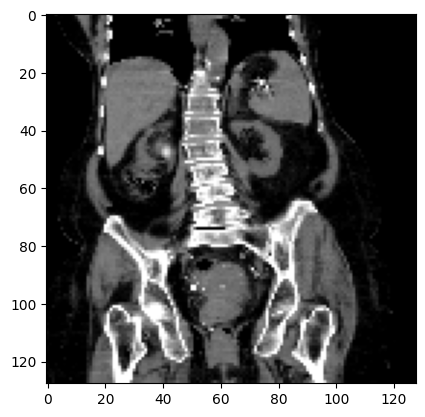

In [6]:
print(data[143][0].shape)
plt.imshow(data[143][0])
plt.show()

In [7]:
# Extract Features and Labels from the data
Features = []
Labels = []
for features , labels in data:
    Features.append(features)
    Labels.append(labels)
Features = np.array(Features)
Labels = np.array(Labels)

In [8]:
Features[5][1]

array([[  0,   0,   0],
       [ 88,  88,  88],
       [  0,   0,   0],
       [  0,   0,   0],
       [  2,   2,   2],
       [  6,   6,   6],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   1,   1],
       [  4,   4,   4],
       [ 15,  15,  15],
       [ 90,  90,  90],
       [  1,   1,   1],
       [  0,   0,   0],
       [  4,   4,   4],
       [ 37,  37,  37],
       [ 75,  75,  75],
       [113, 113, 113],
       [118, 118, 118],
       [121, 121, 121],
       [106, 106, 106],
       [135, 135, 135],
       [ 33,  33,  33],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0

In [9]:
# Shape of Features and Labels
print(Features.shape)
print(Labels.shape)

(1609, 128, 128, 3)
(1609,)


# **Preprocessing**

**Denoising**

In [10]:
def Processed(Processed_images):
    img_per_row = 4
    fig, ax = plt.subplots(nrows = 2, ncols = img_per_row, figsize=(10,10), subplot_kw = dict(xticks = [], yticks = []))
    for row in [0, 1]:
        for col in range(img_per_row):
            if(row * img_per_row + col == 7):
                break
            if(Processed_images[row * img_per_row + col][1] == "Bilateral_Denoised" or Processed_images[row * img_per_row + col][1] == "Wavelet_Denoised" or Processed_images[row * img_per_row + col][1] == "Non_Local_Means"):
                ax[row, col].imshow(Processed_images[row * img_per_row + col][0].astype('float64'), cmap = "gray")
            else:
                ax[row, col].imshow(Processed_images[row * img_per_row + col][0].astype('uint8'), cmap = "gray")
            ax[row, col].set_title(Processed_images[row * img_per_row + col][1])
            plt.axis('off')
    plt.show()

In [11]:
# Filters


# Efficient in reducing gaussian image
# Lowers the image resolution
def AnisotropicFilter_wholedataset(noised_dataset, niter, kappa, gamma, option, size):
    anisotropic_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(anisotropic_dataset.shape[0])):
        anisotropic_dataset[i] = anisotropic_diffusion(noised_dataset[i, :, :, :], niter=niter, kappa=kappa, gamma=gamma, option=option).reshape(size, size, 1)
    return anisotropic_dataset


# Reduce spiky noise
# Non linear filter
# Smoothens the image
# Prevent blur and preserve sharp edges 
# Only better for removing salt and pepper noise
def median_wholedataset(noised_dataset, filtersize, size):
    median_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        median_wholedata[i] = median(noised_dataset[i,:,:,:][:,:,0], np.ones((filtersize, filtersize))).reshape(size, size, 1)
    return median_wholedata


# Regardless of the frequency composition of the signal, eliminate noise while keeping its properties 
# Unable to preserve fine details in case of high noise data.
# There's a chance the wavelet coefficients are biased
def wavelet_wholedataset(noised_dataset, sigma, wavelet_levels, size):
    wavelet_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        wavelet_wholedata[i] = denoise_wavelet(noised_dataset[i,:,:,:], sigma=sigma, channel_axis=-1, wavelet_levels=wavelet_levels, rescale_sigma=True).reshape(size, size, 1)
    return wavelet_wholedata


# Better in preserving edges
# Effectively remove gaussian noise
# Not the best fit for salt and pepper noise
def BilateralFilter_wholedataset(noised_dataset, sigma_color, sigma_spatial, channel_axis, size):
    bilateral_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(bilateral_dataset.shape[0])):
        bilateral_dataset[i] = denoise_bilateral(noised_dataset[i, :, :, :], sigma_color = sigma_color, sigma_spatial=sigma_spatial, channel_axis=channel_axis).reshape(size, size, 1)
    return bilateral_dataset


# Effect for gaussian noise
# Simplicity of algorithm is one of the pros
# Reduce the image details
# Unable to preserve edges
# Denoised images would be blurry.
def GaussianFilter_wholedataset(noised_dataset, sigma):
    gaussian_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(gaussian_dataset.shape[0])):
        gaussian_dataset[i] = nd.gaussian_filter(tuple(noised_dataset[i, :, :, :]), sigma=sigma)
    return gaussian_dataset


# Preserve edges
# Better performance with redundant images
# Expensive, so non-suggestable for larger noise
def non_local_mean(image):
    sigma_est = np.mean(estimate_sigma(image, channel_axis=-1))
    patch_kw = dict(patch_size = 5,      # 5x5 patches
                patch_distance = 6,  # 13x13 search area
                channel_axis = -1)
    denoise_fast = denoise_nl_means(image, h = 0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw)
    return denoise_fast


# Apply bilateral filter with d = 15
# sigmaColor = sigmaSpace = 75
# d: Diameter of each pixel neighborhood.
# sigmaColor: Value of sigma  in the color space. The greater the value, the colors farther to each other will start to get mixed.
# sigmaSpace: Value of sigma  in the coordinate space. The greater its value, the more further pixels will mix together, given that their colors lie within the sigmaColor range.
def cv2bilateralFilter(image, d, sigmaColor, sigmaSpace):
    bilateral = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    bilateral = bilateral.astype('uint8')
    return bilateral




# Execution
# ani = AnisotropicFilter_wholedataset(noised_dataset, 50, 20, 0.2, 1)
# bi = BilateralFilter_wholedataset(noised_dataset, 15, -1)
# gauss = GaussianFilter_wholedataset(noised_dataset, 2)

# median_img = median(Features[0, :, :, :][:,:,0], disk(3), mode = 'constant', cval = 0.0).reshape(128, 128, 1)
# wavelet_img = denoise_wavelet(Features[0, :, :, :], sigma = 0.12, channel_axis = -1,convert2ycbcr=True, method='BayesShrink', mode='soft', rescale_sigma=True).reshape(128, 128, 3)
# bilateral_image = denoise_bilateral(Features[0], sigma_spatial = 10, channel_axis = -1)
# anisotropic_image = anisotropic_diffusion(Features[700,:,:,:][:,:,0], niter = 100, kappa = 10, gamma = 0.02, option=1)
# anisotropic_image = anisotropic_diffusion(Features[700,:,:,:][:,:,0], niter = 50, kappa = 10, gamma = 0.02, option=1)
# anisotropic_image = anisotropic_diffusion(Features[60,:,:,:][:,:,0], niter = 50, kappa = 5, gamma = 0.005, option=1)
# anisotropic_image = anisotropic_diffusion(Features[600,:,:,:][:,:,0], niter = 50, kappa = 5, gamma = 0.000001, option=1)
# anisotropic_image = anisotropic_image.astype('uint8')


# Metrics
def psnr_wholedataset(dataset_original, dataset_denoised):

    sumpsnr = 0
    avgpsnr = 0
    for i in tqdm(range(dataset_original.shape[0])):
        true_min, true_max = np.min(dataset_original[i, :, :, :]), np.max(dataset_original[i, :, :, :])
        dataRange = abs(true_min)+abs(true_max)
        psnr = peak_signal_noise_ratio(dataset_original[i], dataset_denoised[i], data_range=dataRange)
        sumpsnr += psnr
    avgpsnr = sumpsnr/dataset_original.shape[0]     

    return avgpsnr

# psnr_wholedataset(data, noised_dataset)


# Execution
# true_min, true_max = np.min(Features[0]), np.max(Features[0])
# dataRange = abs(true_min) + abs(true_max)
# print("PSNR: ", peak_signal_noise_ratio(Features[143, :, :, :][:,:,0], anisotropic_image, data_range = dataRange))
# print("MSE: ", mean_squared_error(Features[143,:,:,:][:,:,0], anisotropic_image))
# print("SSIM: ", ssim(Features[143, :, :, :][:,:,0], anisotropic_image, multichannel=True, gaussian_weights = True, sigma=1.5, use_sample_covariance=False))


# plt.imshow(np.hstack((wavelet_img, Features[143, :, :, :].reshape(128,128,3))), cmap = "gray")




In [12]:
true_min, true_max = np.min(Features[143]), np.max(Features[143])
dataRange = abs(true_min) + abs(true_max)
bilateral = cv2bilateralFilter(Features[143,:,:,:], 15, 75, 75)
print("PSNR: ", peak_signal_noise_ratio(Features[143,:,:,:], bilateral, data_range = dataRange))
print("MSE: ", mean_squared_error(Features[143,:,:,:], bilateral))
print("SSIM: ", ssim(Features[143,:,:,:], bilateral, multichannel = True, gaussian_weights = True, sigma=1.5, use_sample_covariance=False))

PSNR:  31.786955991118436
MSE:  43.0908203125


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [20]:
Features.shape[0]

1609

IndexError: list index out of range

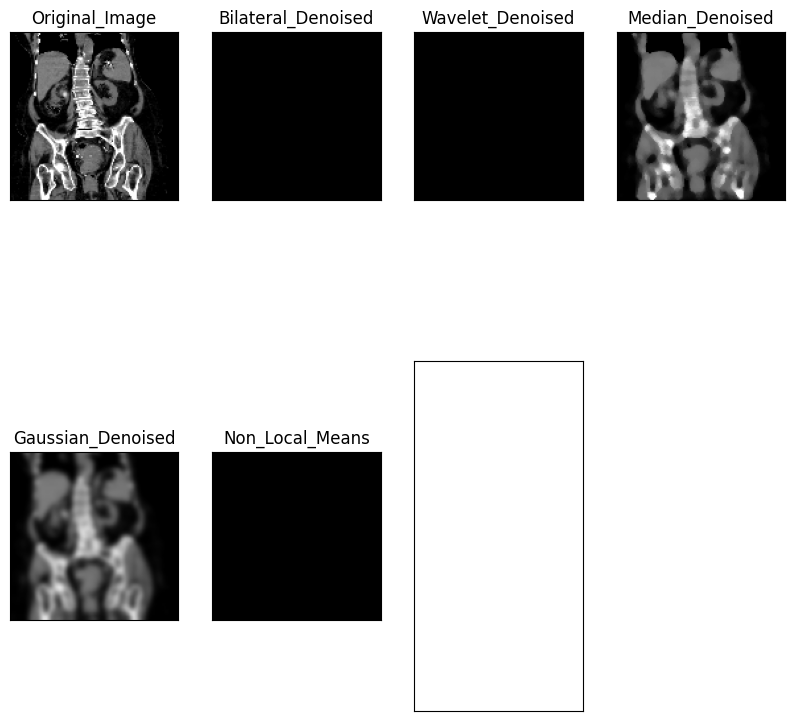

In [26]:
# anisotropic_image = anisotropic_diffusion(Features[143,:,:,:], niter = 50, kappa = 5, gamma = 0.005, option=1)
bilateral_image = denoise_bilateral(Features[143], sigma_spatial = 10, channel_axis = -1)
wavelet_img = denoise_wavelet(Features[143, :, :, :], sigma = 0.12, channel_axis = -1,convert2ycbcr = True, method = 'BayesShrink', mode = 'soft', rescale_sigma = True).reshape(128, 128, 3)
median_img = median(Features[143, :, :, :][:,:,0], disk(3), mode = 'constant', cval = 0.0).reshape(128, 128, 1)
guassian_img = nd.gaussian_filter(tuple(Features[143, :, :, :]), sigma = 2)
non_local_mean_img = non_local_mean(Features[143])

Processed_images = [[Features[143, :, :, :], "Original_Image"], [bilateral_image, "Bilateral_Denoised"], [wavelet_img, "Wavelet_Denoised"], [median_img,"Median_Denoised"], [guassian_img, "Gaussian_Denoised"], [non_local_mean_img, "Non_Local_Means"]]

Processed(Processed_images)

In [27]:
# Denoising the given data with anisotropic Filter
true_min, true_max = np.min(Features[0]), np.max(Features[0])
dataRange = abs(true_min) + abs(true_max)
anis_denoised = []
for i in range(len(Features)):
    anisotropic_image = anisotropic_diffusion(Features[i,:,:,:], niter = 100, kappa = 10, gamma = 0.02, option = 1)
    anis_denoised.append(anisotropic_image)
anis_denoised = np.array(anis_denoised)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

**Cropping, Thersholding(or masking), Edge Detection, Morphological Analysis**

In [28]:
def crop(image_to_be_cropped):
    height, width = image_to_be_cropped.shape[:2]
    start_row, start_col = int(height * .24), int(width * .24)
    end_row, end_col = int(height * .78), int(width * .78)
#     start_row, start_col = int(height * .24), int(width * .24)
#     end_row, end_col = int(height * .42), int(width * .78)
    cropped_image = image_to_be_cropped[start_row:end_row, start_col:end_col]
    return cropped_image

def threshold(img, thresh1 = 254):
    return ((img > thresh1) * 255).astype('uint8')


# Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. 
def edge_detection(Image):
    img = cv2.Canny(Image, 100, 200)
    return img

# To see the pixel values division in the images
def hist_plot(Image):
    plt.hist(Image.flat, bins = 100, range = (0, 255))
    plt.show()

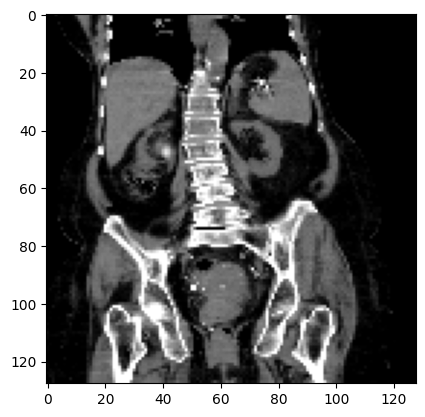

In [29]:
# Convert BGR image to Gray Scale image
gray_image = cv2.cvtColor(data[143][0], cv2.COLOR_BGR2GRAY)

# expanding dimensions from 128,128 to 128,128,1
gray_image = np.expand_dims(gray_image, axis = -1)

plt.imshow(gray_image, cmap = "gray")
plt.show()

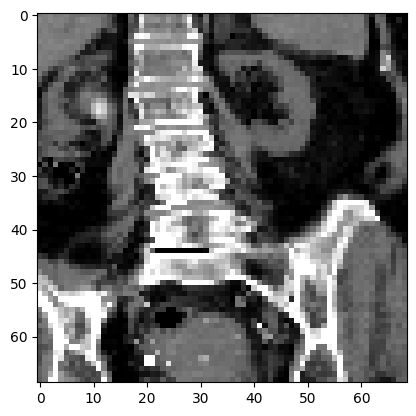

In [30]:
# Crop a Image
cropped_image = crop(Features[143,:,:,:])
plt.imshow(cropped_image)
plt.show()

In [31]:
cropped_image.shape

(69, 69, 3)

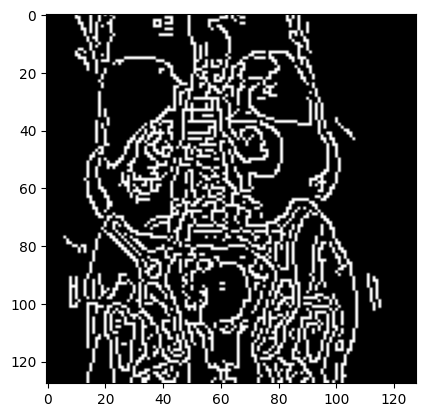

In [32]:
# Edge Detection
img = edge_detection(gray_image)
plt.imshow(img, cmap = "gray")
plt.show()

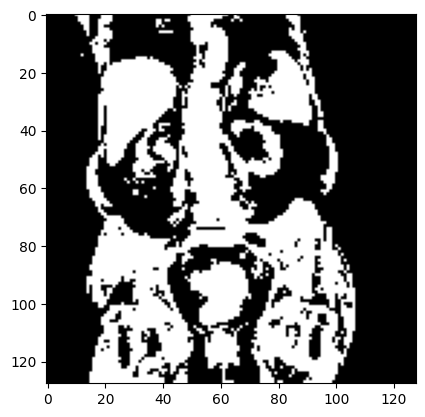

In [33]:
# Threshold masking using OTSU method
# Automatic Thresholding
# Otsu's method looks at every possible value for the threshold between background and foreground, calculates the variance within each of the two clusters, and selects the value for which the weighted sum of these variances is the least.
re, th = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(th, cmap = "gray")
plt.show()

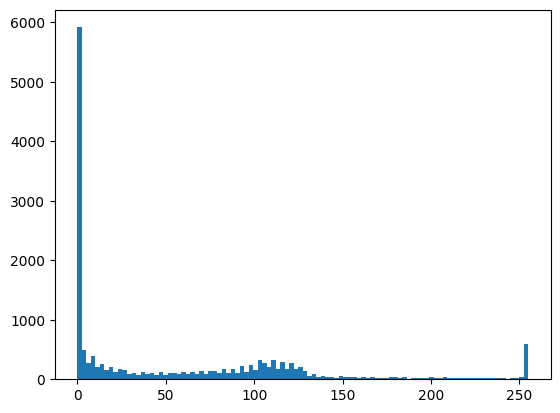

In [34]:
# See the pixel values division in the images
hist_plot(gray_image)

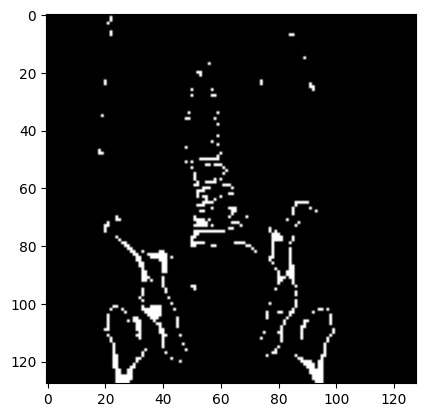

In [35]:
# Manual Thresholding on the basis of pixel divisions
img = threshold(gray_image)
plt.imshow(img, cmap = "gray")
plt.show()

In [36]:
# Mask of Image

# HSV or Hue Saturation Value is used to separate image luminance from color information. This makes it easier when we are working on or need luminance of the image/frame. HSV also used in situations where color description plays an integral role.
# Hue, in the context of color and graphics, refers to the attribute of a visible light due to which it is differentiated from or similar to the primary colors
# Saturation describes the intensity of the color.
# Hue is determined by the dominant wavelength of the visible spectrum. It is the attribute that permits colors to be classified as red, yellow, green, blue, or an intermediate color. Saturation pertains the amount of white light mixed with a hue.
# Value works in conjunction with saturation and describes the brightness or intensity of the color, from 0 to 100 percent, where 0 is completely black, and 100 is the brightest and reveals the most color.

lower_yellow = np.array([35, 255, 255])
upper_yellow = np.array([25, 50, 70])
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])
lower_white = np.array([180, 18, 255])
upper_white = np.array([0, 0, 231])
lower_black = np.array([180, 255, 30])
upper_black = np.array([0, 0, 0])

bgr_image = cv2.cvtColor(Features[143,:,:][:,:,0], cv2.COLOR_GRAY2BGR)

hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower_black, upper_black)

detected_output = cv2.bitwise_and(hsv, hsv, mask =  mask)
plt.imshow(detected_output, cmap = "gray")
plt.show()

error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<1,-1,-1>,struct cv::impl::A0x981fb336::Set<3,4,-1>,struct cv::impl::A0x981fb336::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 4 (CV_32S)


In [37]:
# Crop all the input images
Cropped_Features = []
for i in range(len(Features)):
    cropped_image = crop(Features[i,:,:,:])
    Cropped_Features.append(cropped_image)
Cropped_Features = np.array(Cropped_Features)

In [40]:
# Denoise all the input images with Bilateral Filte

# On original images
bil_de = []
for i in range(len(Features)):

    bilateral_de = cv2.bilateralFilter(Features[i].astype(np.float32), 15, 75, 75)
    bil_de.append(bilateral_de)
bil_de = np.array(bil_de)


# On cropped images
bilateral_denoised = []
for i in range(len(Cropped_Features)):
    bilateral = cv2.bilateralFilter(Cropped_Features[i].astype(np.float32), 15, 75, 75)
    bilateral_denoised.append(bilateral)
bilateral_denoised = np.array(bilateral_denoised)

In [41]:
# Threshold masking on all the input images

# Original
thresholded = []
for i in range(len(bilateral_denoised)):
    temp = threshold(bilateral_denoised[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)


# Cropped
thresholded = []
for i in range(len(Cropped_Features)):
    temp = threshold(Cropped_Features[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)

# **Splitting of Data**

In [42]:
print(Features.shape)
print(Labels.shape)

(1609, 128, 128, 3)
(1609,)


In [43]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Features, Labels, test_size = 0.30, random_state = 80, shuffle = True)

print(len(Xtrain), len(Xtest), len(Ytrain), len(Ytest))

# Converting the list to a numpy array as a requirement for the input in fit function.
Xtrain=np.array(Xtrain)
Xtest=np.array(Xtest)
Ytrain=np.array(Ytrain)
Ytest=np.array(Ytest)

1126 483 1126 483


# **Different types of Model Training and Testing**

**Convolutional Neural Network(CNN)**

In [45]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Настройка TensorFlow для динамического выделения памяти GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Доступные GPU: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        # В случае возникновения ошибки при установке динамического выделения памяти
        print(e)
else:
    print("GPU не найдены. Модель будет обучаться на CPU.")

Доступные GPU: ['/physical_device:GPU:0']


In [55]:
from keras.metrics import Recall

# CNN: A convolutional neural network (CNN or ConvNet) is a network architecture for deep learning that learns directly from data. CNNs are particularly useful for finding patterns in images to recognize objects, classes, and categories. They can also be quite effective for classifying audio, time-series, and signal data.

# Model 1
model1 = Sequential([(Conv2D(128, 3, 3, input_shape=(128, 128, 3))),Activation('relu'),
                    MaxPool2D(pool_size=(2, 2)),Conv2D(128, 3, 3),
                    Activation('relu'), MaxPool2D(pool_size=(2, 2)),Flatten(),Dense(128),
                    Activation('relu'),Dropout(0.4),
                    Dense(1),Activation('sigmoid'),])




# Model 2
model2 = Sequential([Conv2D(filters = 32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(128,77,3)),
MaxPool2D(pool_size=(2,2),strides=2),
Conv2D(filters = 64,kernel_size=(3,3),activation='relu',padding='same'),
MaxPool2D(pool_size=(2,2),strides=2),
Flatten(),
Dense(units = 1,activation='softmax')
])


# Model 3
model3 = Sequential()

model3.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3), padding='same'))
model3.add(MaxPool2D(2))
model3.add(Dropout(0.2))


model3.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.4))

model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.5))


model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))

model3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))

model3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.6))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))

model3.add(Dense(1, activation='sigmoid'))

model1.summary()
model2.summary()
model3.summary()

# compile function configures the Sequential model for training.
# Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Optimizers are used to solve optimization problems by minimizing the function.
# Crossentropy loss function when there are two or more label classes.
# We expect labels to be provided as integers.


# model.compile(optimizer = Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model3.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 42, 42, 128)       3584      
                                                                 
 activation_20 (Activation)  (None, 42, 42, 128)       0         
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 activation_21 (Activation)  (None, 7, 7, 128)         0         
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 3, 3, 128)        0         
 g2D)                                                

In [56]:
# verbose=2 just specifies how much output to the console we want to see during each epoch of training. The verbosity levels range from 0 to 2, so we're getting the most verbose output.
# model.fit(Xtrain, Ytrain, epochs = 50, batch_size = 20, verbose = 2)

# Define a callback for early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

# Train the model
history = model3.fit(Xtrain, Ytrain, epochs = 200, batch_size = 20, callbacks = [early_stopping])


#To this function, we pass in the test samples x, specify a batch_size, and specify which level of verbosity we want from log messages during prediction generation. The output from the predictions won't be relevant for us, so we're setting verbose=0 for no output.
#Note that, unlike with training and validation sets, we do not pass the labels of the test set to the model during the inference stage.
predictions = model3.predict(x = Xtest, batch_size = 20, verbose = 0)
Accuracy = model3.evaluate(Xtest, Ytest, verbose = 0)
print("Accuracy: ", Accuracy[1] * 100)

Epoch 1/200
57/57 [==============================] - 2s 18ms/step - loss: 3.2289 - accuracy: 0.5266
Epoch 2/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6981 - accuracy: 0.5142
Epoch 3/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6975 - accuracy: 0.5133
Epoch 4/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6945 - accuracy: 0.5213
Epoch 5/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6947 - accuracy: 0.5222
Epoch 6/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6970 - accuracy: 0.5266
Epoch 7/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6962 - accuracy: 0.5027
Epoch 8/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6946 - accuracy: 0.4876
Epoch 9/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6974 - accuracy: 0.4938
Epoch 10/200
57/57 [==============================] - 1s 16ms/step - loss: 0.6901 - accuracy: 0.5213

**Confusion Matrix**

In [57]:
# cm = confusion_matrix(y_true = Ytest, y_pred = np.argmax(predictions,axis=-1))
cm = confusion_matrix(Ytest , (predictions > 0.75) * 1)

In [58]:
# Function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[205  24]
 [ 20 234]]


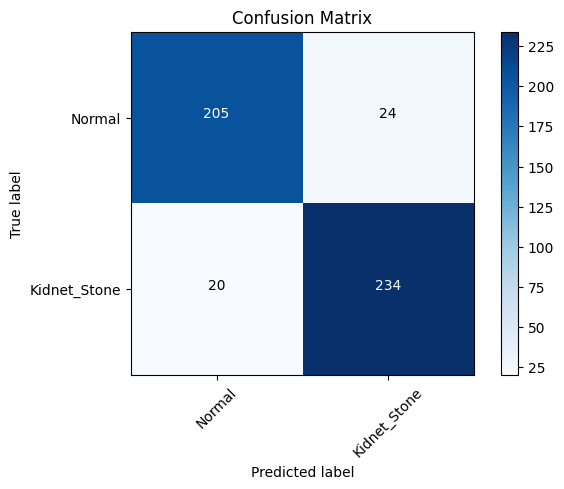

In [59]:
cm_plot_labels = ['Normal','Kidnet_Stone']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [ ]:
def image_prediction(img):
    plt.imshow(img)
    img1=img.reshape(1,128,128,3)
    predict = model3.predict(img1)
    if ((predict > 0.75) * 1):
        print("The condition is normal and stable.")
    else:
        print("Person is having kidney stone(s)")

In [ ]:
image_prediction(Xtest[143])

In [ ]:
image_prediction(Xtest[50])

In [60]:
# Save CNN Model
model3.save('kidney_stones_model.h5')

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Загружаем и изменяем размер изображения
    x = image.img_to_array(img)  # Преобразуем изображение в массив numpy
    x = np.expand_dims(x, axis=0)  # Добавляем дополнительное измерение, т.к. модель ожидает батч изображений
    x = preprocess_input(x)  # Предварительная обработка, как для обучения модели (зависит от вашей модели)
    return x

In [13]:
import innvestigate
import keras
tf.compat.v1.disable_eager_execution()
saved_model = tf.keras.models.load_model("kidney_stones_model.h5")
model_wo_softmax = keras.models.Model(inputs=saved_model.inputs,
                                      outputs=saved_model.layers[-2].output)
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_", model_wo_softmax)

img_path = 'C:/Users/nero1/PycharmProjects/pythonProject3/CT_SCAN/Kidney_stone/KS6.png'
X = load_and_preprocess_image(img_path)
relevances = analyzer.analyze(X)

KeyError: "No analyzer with the name 'lrp.sequential_preset_' could be found. All possible names are: ['input', 'random', 'gradient', 'gradient.baseline', 'input_t_gradient', 'deconvnet', 'guided_backprop', 'integrated_gradients', 'smoothgrad', 'lrp', 'lrp.z', 'lrp.epsilon', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat', 'lrp.sequential_preset_b_flat_until_idx', 'deep_taylor', 'deep_taylor.bounded']"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


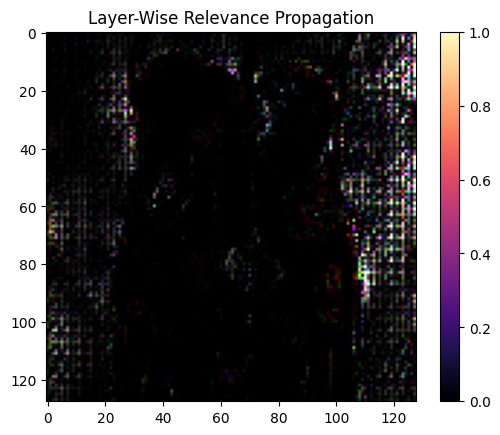

In [12]:
import matplotlib.pyplot as plt

# Предполагается, что relevances - это массив значений релевантности для вашего изображения
relevance = relevances[0]  # Берем релевантность для первого (и единственного) образца
relevance = np.squeeze(relevance)  # Убираем лишние измерения

# Визуализируем тепловую карту релевантности
plt.imshow(relevance, cmap='magma')
plt.colorbar()
plt.title('Layer-Wise Relevance Propagation')
plt.show()